In [1]:
from qiskit import QuantumCircuit, transpile, quantum_info
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
import numpy as np

In [7]:
# Function to generate a random number uniformly between 0 and 2^n - 1 using 1 qubit on AerSimulator
# NOTE: We would not recommend to run this on ibm hardware .
def helper(n):
    # Create a quantum circuit with one qubit
    qc = QuantumCircuit(1)
    
    # Apply Hadamard gate to create superposition state (|0> + |1>)
    qc.h(0)
    qc.measure_all()

    backend = AerSimulator()
    transpile_qc = transpile(qc, backend=backend, optimization_level=2)
    bits = []
    sampler = Sampler(backend)
    
    # Repeat the measurement n times to generate n bits
    for _ in range(n):
        # Run the circuit and retrieve measurement result
        job = sampler.run([(transpile_qc, None)])
        result = job.result()
        counts = result[0].data.meas.get_counts()
        n = list(counts.keys())[0]
        # Append the measured bit (0 or 1) to the list
        bits.append(n)

    # Join the bits and convert the binary string to an integer
    random_number = int("".join(bits), 2)
    
    # Return the final random number
    return random_number

# Function to generate a random integer uniformly within the range [min_val, max_val]
def random_number_generator_v1(min_val,max_val):
    #no. of qubits required
    n = (max_val - min_val+1).bit_length()

    # Infinite loop until a valid number is generated
    while 7:
        # Generate a random number using the helper function
        ans = helper(n)
        if ans + min_val <= max_val:
            return ans + min_val


# Example

In [8]:
for _ in range(10):
    print( random_number_generator_v1(0,100) )

37
57
80
5
48
50
4
59
93
56


## Proof of Uniformity of Output of `random_number_generator_v1`

For simplicity, we'll prove for a specific case where $\text{min\_val} = 0$ and $\text{max\_val} = 100$.

For this case, we'll need 7 qubits, as it will be able to generate random numbers in the range $[0, 2^7 - 1] = [0, 127]$, which is the smallest available superset of the form $[0, 2^n - 1]$.

Now our function will call the `helper` function to generate a random number in $[0, 127]$, uniformly. Thus, the probability of the output of the helper function being equal to $i$ is:

$$
P(\text{output of helper function} = i) = \frac{1}{128} \quad \text{for all } i \in [0, 127].
$$

However, we want only random numbers in the range $[0, 100]$. Therefore, our function will reject any output that falls outside this range and call the `helper` function again. This process will repeat until it gets a random number in the required range.

Now, for $i$ in the range $[0, 100]$:

$$
P(\text{final output} = i) = \frac{1}{128} + \left(\frac{27}{128}\right) \left(\frac{1}{128}\right) + \left(\frac{27}{128}\right)^2 \left(\frac{1}{128}\right) + \ldots
$$

This is a geometric series where the first term $ a = \frac{1}{128} $ and the common ratio $ r = \frac{27}{128} $.

Using the formula for the sum of an infinite geometric series $ S = \frac{a}{1 - r} $:

$$
P(\text{final output} = i) = \frac{1}{128} \cdot \frac{1}{1 - \frac{27}{128}} = \frac{1}{128} \cdot \frac{128}{128 - 27} = \frac{1}{101}.
$$

Additionally, there are 101 integers in the range $[0, 100]$ (including both endpoints).

Hence, our output is uniformly distributed.
(If you need further assistance to understand the proof, contact us ;) 


In [2]:
# Uncomment and put your QXToken below in IBM QPU to run the function

#-------------------------------------------------------------------------------------
service = QiskitRuntimeService(channel = "ibm_quantum", # ibm_cloud
                               token = "18685ae0908f29a7551948bfb2bcd7021bf74b56621eb98b9616fbe7705282f04aa2ee1d7ef36db473645d067c34dc9ec591050f4b214203d13bd22816b39649")
backend = service.least_busy(simulator=False, operational=True)
#-------------------------------------------------------------------------------------

# backend = AerSimulator()
backend

<IBMBackend('ibm_brisbane')>

# For IBM QPU or simulator 
The function ,in the cell below, creates a quantum circuit with `n` qubits, applies 
Hadamard gates to all qubits to create a superposition of states, 
measures the qubits to collapse their states, and retrieves the 
measurement results from a specified quantum backend (e.g. 'ibm_brisbane').

Parameters:
- n (int): The number of qubits to use in the quantum circuit.
- backend (Backend): The quantum backend to execute the circuit on, 
                     typically a cloud-based quantum processing unit (QPU).

Returns:
- int: A true random number generated from the measurement results,
       represented as an integer derived from the first measurement 
       outcome in binary form.

In [9]:
# Generate a true random number using a quantum circuit.
def quantum_random_number_generator_v1(n,backend):
    # Initialize a quantum circuit with n qubits
    qc = QuantumCircuit(n)
    
    # Apply Hadamard gates to each qubit to create superposition
    for i in range(n):
        qc.h(i)
    
    # Measure all qubits to collapse their states into classical bits
    qc.measure_all()
    
    # Transpile the circuit for the specified backend with optimization
    transpile_qc = transpile(qc, backend=backend, optimization_level=2)

    # Create a sampler for the quantum backend
    sampler = Sampler(backend)

    # Run the transpiled circuit and request one measurement result
    job = sampler.run([(transpile_qc, None, 1)])
    
    # Retrieve the result of the measurement
    result_qc = job.result()
    
    # Extract the measurement counts and get the keys (bitstrings)
    I = result_qc[0].data.meas.get_counts().keys()
    
    # Convert the first bitstring to an integer and return it
    return int(list(I)[0], 2)



We know that any quantum circuit have some noise. We utilise "Pauli Twirling" to mitigate the noise and updated the function below. 

Input/Ouput format is same.

In [10]:

def quantum_random_number_generator_v2(n,backend):
    qc = QuantumCircuit(n)
    
    for i in range(n):
        qc.h(i)
        
    qc.measure_all()
    
    transpile_qc = transpile(qc, backend=backend, optimization_level=2)
    
    # Define options for twirling to enhance randomness
    options = {
        "twirling": {
            "enable_gates": True,
            "enable_measure": True,
            "strategy": "active-circuit"
        }
    }

    # Create a sampler with twirling options for the quantum backend
    sampler_twirl = Sampler(backend, options=options)

    # Run the transpiled circuit with the twirling sampler and request one measurement result
    job_twirl = sampler_twirl.run([(transpile_qc,None,1)])

    
    result_qc = job.result()
    
    I = result_qc[0].data.meas.get_counts().keys()
    
    return int(list(I)[0],2)

# Smaller alias for ease of calling
qrng = quantum_random_number_generator_v1     

# Analysis
In the cell below, we compared normal method and noise-corrected using "Pauli Twirling" method.

In [3]:
n = 3
shots = 800
qc = QuantumCircuit(n)

for i in range(n):
    qc.h(i)
    
qc.measure_all()

transpile_qc = transpile(qc, backend=backend, optimization_level=3)

# Without Pauli Twirling

sampler = Sampler(backend)
job = sampler.run([(transpile_qc,None,shots)])
print(job.job_id())


# Using Pauli Twirling

options = {
    "twirling": {
        "enable_gates": True,
        "enable_measure": True,
        "strategy": "active-circuit"
    }
}

sampler_twirl = Sampler(backend, options=options)
sampler_twirl.options.dynamical_decoupling.enable = True

job_twirl = sampler_twirl.run([(transpile_qc,None,shots)])
print(job_twirl.job_id())


cwb9tfsjzdhg0089vga0
cwb9tgabhxtg008se0d0


In the cell below, we are comparing the counts of raw data and Noice-corrected data using "Pauli Twirling".

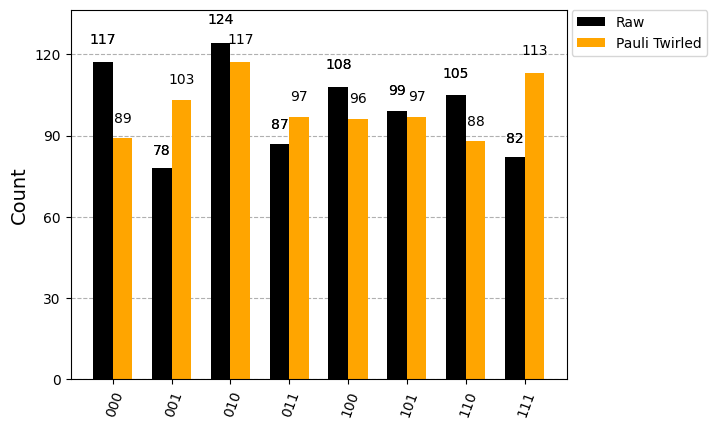

In [4]:
job = service.job('cwb9tfsjzdhg0089vga0')
job_twirl = service.job('cwb9tgabhxtg008se0d0')

result_qc_raw = job.result()
result_qc_twirl = job_twirl.result()

counts_qc_raw = result_qc_raw[0].data.meas.get_counts()
counts_qc_twirl = result_qc_twirl[0].data.meas.get_counts()

plot_histogram([counts_qc_raw, counts_qc_twirl], legend=['Raw', 'Pauli Twirled'],color=["Black","orange"])


In the following cell, we present the variances for both the raw data and the noise-corrected data obtained through "Pauli Twirling." 

It's important to note that a lower standard deviation indicates a more reliable and stable dataset. As you can see, the standard deviation for the noise-corrected data is significantly lower than that of the raw data. This suggests that the noise correction has effectively improved the quality of the data, making it the better choice for analysis.


In [6]:
std_raw = np.std(list(counts_qc_raw.values()))
std_twirl = np.std(list(counts_qc_twirl.values()))

print('Standard deviation of Raw Data without any noise mitigation is applied:', std_raw)
print('Standard deviation of Data with Pauli Twirling as noise mitigation method:', std_twirl)

Standard deviation of Raw Data without any noise mitigation is applied: 15.540270267920054
Standard deviation of Data with Pauli Twirling as noise mitigation method: 9.785192895390463


# Bonus
So far we have generated a quantum state with `2^n` number of equally possible outcomes.
But what about general `n`?

We did some experiments and the results are below.


In [5]:
# generating 3 equally possible quantum states
q3 = QuantumCircuit(2)

q3.ry(2*np.arccos(1/np.sqrt(3)), 0)
q3.cx(0, 1)
q3.ch(0, 1)
q3.z(1)
q3.cx(1,0)

#q3.draw('mpl')

quantum_info.Statevector(q3).draw('latex') 


<IPython.core.display.Latex object>

In [7]:
# generating 5 equally possible quantum states
q5 = QuantumCircuit(3)

theta = 2 * np.arccos(np.sqrt(3/5))
q5.ry(theta,0)
# q5.h(1)
# q5.cx(1,2)
q5.ch(0,2)
q5.x(0)
q5.cry(2*np.arccos(1/np.sqrt(3)) , 0, 1)
q5.cx(1, 2)
q5.ch(1, 2)


q5.draw('mpl')

quantum_info.Statevector(q5).draw('latex')


<IPython.core.display.Latex object>

We're further trying to generate 6 equally possible quantum states, but haven't succeed yet.

In [ ]:
#q6 = QuantumCircuit(3)

# q6.h(0)
# q6.cry(2*np.arccos(1/np.sqrt(3)),0,1)
# q6.ch(1,2)

# q6.x(0)
# q6.cry(2*np.arccos(1/np.sqrt(3)),0,1)
# #q6.ch([0,1],2)

# quantum_info.Statevector(q6).draw('latex')

<center>
Thank You
</center>